### Packages

In [1]:
# NumCosmo:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

import matplotlib.pyplot as plt
import scipy
import numpy as np
from sympy import *
import scipy.stats as scs

# Necessary functions:

from numpy import sqrt, log10, sinh, exp
from numpy import log as ln

#Calculus:
from scipy.integrate import quad #Integrate
from sympy import diff, Symbol, symbols #Derivative
from scipy.optimize import minimize

c = 3*(10**5)
#c =1

### NumCosmo Settings

In [2]:
Ncm.cfg_init ()
cosmo = Nc.HICosmoDEXcdm() #Cosmology object

### Data

In [3]:
ser = Ncm.Serialize.new(0)
data = ser.from_file("/home/cinthia/NumCosmo/data/nc_data_snia_diag_legacy.obj")
lenz = data.y.len()

muobs = []
sigma = []
zobs = []
for i in range(lenz):
    mi = data.y.get(i)
    si = data.sigma.get(i)
    zi = data.x.get(i)
    
    muobs.append(mi)
    sigma.append(si)
    zobs.append(zi)

muobs = np.array(muobs)
zobs = np.array(zobs)
sigmaobs = np.array(sigma)

### A) Likelihood (-2ln L) ($\Omega_{k0} = \Omega_{r0} = 0$ )

In [4]:
def Dl(z, theta):
#Theta
    H0, Omega_m0, Omega_l0  = theta[0], theta[1], theta[2]

#Hubble function
#    E2z = Omega_l0 + Omega_k0*((1 + z) ** 2) + Omega_m0*((1 + z) ** 3) + Omega_r0*((1 + z) ** 4) 
#    Ez = E2z ** 0.5
    

#Comoving distance
    def integ(b):

        int_arg = lambda z: 1/((Omega_l0 + (Omega_m0 * ((1 + z) ** 3))) ** 0.5)
        result = quad(int_arg, 0, b)
        return result[0]

    dc_list = []
    for i in range(lenz):
        d = integ (z[i])     #(* c/H0)   
        dc_list.append(d)

    dc = np.array(dc_list)      
    Dc =  dc     #( * H0/c)


#Temporal comoving distance
#     if Omega_k0 == 0:
#         Dt = Dc
#     else:
#         Dt = sinh((sqrt(Omega_k0)) * Dc) / sqrt(Omega_k0)
    Dt = Dc

    
#Luminosity distance
    D_l = (1 + z) * Dt

    return D_l

def mu(z, theta): #This function calculates the modular distance
#Modular distance
    H0, Omega_m0, Omega_l0  = theta[0], theta[1], theta[2]
    DL = Dl(z, theta)
    mu = ( 5 * log10(DL) ) + 25 + ( 5 * log10(c / H0))
    
    return mu 

def f_2lnL(theta): #This function calculates -2lnL (L is the Likelihood).
    arg = []
    mu_z = mu(zobs,theta)
    for i in range(lenz):
        argi = ( ( mu_z[i] - muobs[i] ) ** 2 ) / ( sigmaobs[i] ** 2 )
        arg.append(argi)
        
    return sum(arg)  


### Best fit

In [5]:
def fit():
    x0 = [70.0, 0.25, 0.70]
    x0_np = np.array(x0)
    bnds = ((0, None), (0, 1.0), (0, 1.0))
    
    f = minimize(f_2lnL, x0_np, bounds = bnds, method='Nelder-Mead', tol=1e-6)
    
    return f

fit = fit()

print(f' [H0 Omega_m0 Omega_l0] \n', fit.x)

 [H0 Omega_m0 Omega_l0] 
 [71.11068429  0.25476161  0.71600742]


### Fisher matrix

In [6]:
#Parameters and data
theta = fit.x
H0 = theta[0]
z = zobs

# factor: del(dc)/delOmega_lambda/m
def dOm(z, Omega):
    dc_list = []
    for i in range(lenz):
        
        H0, Omega_m0, Omega_l0  = theta[0], theta[1], theta[2]
        
        if Omega == 1:        #Omega_Lambda case
            int_arg = lambda z: -(0.5) * ((Omega_l0 + (Omega_m0 * ((1 + z) ** 3)))) ** (3/2)
            d = quad(int_arg, 0, z[i])
        
        else:                #Omega_m case
            
            int_arg = lambda z: -((1 + z) ** 3) * (0.5) * ((Omega_l0 + (Omega_m0 * ((1 + z) ** 3)))) ** (3/2)
            d = quad(int_arg, 0, z[i])
        
               
        dc_list.append(d[0])

    return np.array(dc_list)


#delmu/delH0
delmuH0 =  []

#delmu/delOmegalambda
delmuOL = []

#delmu/delOmegam
delmuOM = []

for k in range(lenz):
    delmuH0i =(- 5) / (H0 * ln(10))
    delmuOLi = (5 / (Dl(z, theta)[k] * ln(10)) * dOm(zobs, 1)[k])
    delmuOMi = (5 / (Dl(z, theta)[k] * ln(10)) * dOm(zobs, 2)[k])
    delmuOL.append(delmuOLi)
    delmuOM.append(delmuOMi)
    delmuH0.append(delmuH0i)


der = [delmuH0, delmuOL, delmuOM] #list of derivatives from mu

#Fisher Matrix
list_mn = []
for n in der:
    list_m = []
    for m in der:
        list_d = []
        for i in range(lenz):
            di = (1 / (sigma[i]) ** 2) * ( n[i] * m[i])
            list_d.append(di)
        list_m.append(sum(list_d))
    list_mn.append(list_m)
    
fisher_matrix = np.array(list_mn)                
print(f'The Fisher Information Matrix, Fij = < del(-lnL)/deltheta_i deltheta_j> (theta = [H0, OmegaLambda, Omegam]), is: \n', fisher_matrix)                


The Fisher Information Matrix, Fij = < del(-lnL)/deltheta_i deltheta_j> (theta = [H0, OmegaLambda, Omegam]), is: 
 [[4.20953415e+00 1.50749550e+02 2.95937950e+02]
 [1.50749550e+02 5.44394992e+03 1.11327621e+04]
 [2.95937950e+02 1.11327621e+04 2.72277427e+04]]


### Confidence Region

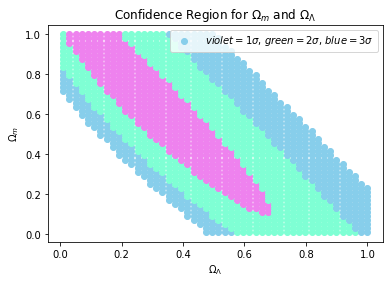

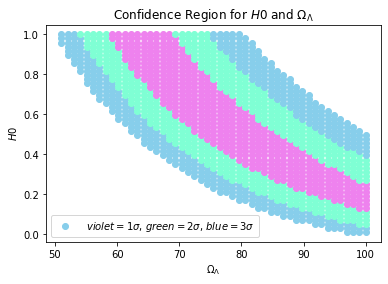

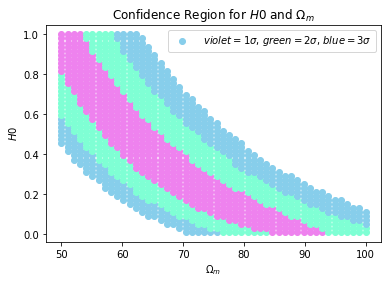

In [13]:
#chi² for 1sigma, 2sigma, 3sigma

chi_list = [scs.chi2.ppf(0.6827, 2), scs.chi2.ppf(0.9545, 2), scs.chi2.ppf(0.9973, 2)]

#-2lnL from the best fit
theta_fit = fit.x
f2lnL = f_2lnL(theta_fit)

#Intervals to the confidance test and plot
int1 = np.linspace(50 ,100, 50)
int2 = np.linspace(0.01 ,1, 50)
int3 = np.linspace(0.01 ,1, 50)
inter =[int1, int2, int3]

#Define the confidence interval and plot
for k in range(3):
    for i in range(50):
        for j in range(50):

            theta1 = [theta_fit[0], inter[1][i], inter[2][j]]      #fixing theta[0]
            theta2 = [inter[0][i], theta_fit[1], inter[2][j]]      #fixing theta[1]
            theta3 = [inter[0][i], inter[1][j], theta_fit[2]]      #fixing theta[2]
            theta = [theta1, theta2, theta3]

            lambda_f = (f_2lnL(theta[k])/ (f2lnL))
            
            intervals =[[inter[1][i], inter[2][j]], [inter[0][i], inter[2][j]],
                        [inter[0][i], inter[1][j]]]
                        
            if  lambda_f < chi_list[0]:
                plt.scatter(intervals[k][0], intervals[k][1], color = 'violet')
                

            elif chi_list[0] < lambda_f < chi_list[1]:
                plt.scatter(intervals[k][0], intervals[k][1], color = 'aquamarine')
                

            elif chi_list[1] < lambda_f < chi_list[2]:
                plt.scatter(intervals[k][0], intervals[k][1], color = 'skyblue')
                

    #Plot settings    
    labels = [['\Omega_m','\Omega_\Lambda'], ['H0', '\Omega_\Lambda'], ['H0', '\Omega_m']]
    plt.title(f'Confidence Region for ${labels[k][0]}$ and ${labels[k][1]}$')
    plt.ylabel(f'${labels[k][0]}$')
    plt.xlabel(f'${labels[k][1]}$')
    plt.legend([f' $violet = 1\sigma$, $green = 2\sigma$, $blue = 3\sigma$ '])
    plt.show()



### B) Likelihood (-2ln L)  and best fit (with all parameters free)

In [14]:
def Dl_all(z, theta):
#Theta
    H0, Omega_k0, Omega_m0, Omega_l0, Omega_r0  = theta[0], theta[1], theta[2], theta[3], theta[4]

#Comoving distance
    def integ(b):

        int_arg = lambda z: 1 / (Omega_l0 + Omega_k0 * ((1 + z) ** 2) + Omega_m0 * ((1 + z) ** 3) + Omega_r0 * ((1 + z) ** 4)) ** 0.5
        result = quad(int_arg, 0, b)
        return result[0]

    dc_list = []
    for i in range(lenz):
        d = integ (z[i])     #(* c/H0)   
        dc_list.append(d)

    dc = np.array(dc_list)      
    Dc =  dc     #( * H0/c)

# Temporal comoving distance
    if Omega_k0 == 0:
        Dt = Dc
    else:
        Dt = (sinh((Omega_k0 ** 0.5)) * Dc) / (Omega_k0 ** 0.5)
        
#Luminosity distance
    D_l = (1 + z) * Dt

    return D_l



def mu_all(z, theta): #This function calculates the modular distance

    H0 =theta[0]
    
    DL = Dl_all(z, theta)
    mu = ( 5 * log10(DL) ) + 25 + ( 5 * log10(c / H0))
    
    return mu 



def f_2lnL_all(theta): #This function calculates -2lnL (L is the Likelihood).
    arg = []
    mu_all_z = mu_all(zobs,theta)
    for i in range(lenz):
        argi = ((mu_all_z[i] - muobs[i] ) ** 2 ) / ( sigmaobs[i] ** 2 )
        arg.append(argi)
        
    return sum(arg)  


In [15]:
#Best fit (all parameters free)

def fit_all():
    x0 = [70.0, 0.02, 0.25, 0.70, 1e-05]
    x0_np = np.array(x0)
    bnds = ((0, None),(0, 1.0), (0, 1.0), (0, 1.0),(0, 1.0))
    
    f = minimize(f_2lnL_all, x0_np, bounds = bnds, method='Nelder-Mead', tol=1e-6)
    
    return f

fit_all = fit_all()

print(f' [H0 Omega_k0 Omega_m0 Omega_l0 Omega_r0] \n',fit_all.x) 

 [H0 Omega_k0 Omega_m0 Omega_l0 Omega_r0] 
 [7.06359151e+01 2.18015388e-06 2.58185962e-01 7.25666979e-01
 5.89644020e-06]


In [16]:
#Fisher Matrix (all parameters free)

#Parameters and data
theta = fit_all.x
H0 = theta[0]
z = zobs

# factor: del(dc)/delOmega_lambda/m
def dOm(z, Omega):
    dc_list = []
    for i in range(lenz):
        
        H0, Omega_m0, Omega_k0, Omega_l0, Omega_r0  = theta[0], theta[1], theta[2], theta[3], theta[4]
        
        if Omega == 1:        #Omega_Lambda case
            int_arg = lambda z: -(0.5) * ((Omega_l0 + (Omega_m0 * ((1 + z) ** 3)))) ** (3/2)
            d = quad(int_arg, 0, z[i])
        
        elif Omega == 2:   #Omega_m case
            int_arg = lambda z: -((1 + z) ** 3) * (0.5) * ((Omega_l0 + (Omega_m0 * ((1 + z) ** 3)))) ** (3/2)
            d = quad(int_arg, 0, z[i])
        
        elif Omega == 3:   #Omega_k case
            int_arg = lambda z: -((1 + z) ** 2) * (0.5) * ((Omega_l0 + (Omega_m0 * ((1 + z) ** 3)))) ** (3/2)
            d = quad(int_arg, 0, z[i])
        
        else:                 #Omega_l case
            int_arg = lambda z: -((1 + z) ** 4) * (0.5) * ((Omega_l0 + (Omega_m0 * ((1 + z) ** 3)))) ** (3/2)
            d = quad(int_arg, 0, z[i])
        
        dc_list.append(d[0])

    return np.array(dc_list)


#delmu/delH0
delmuH0 =  []

#delmu/delOmegalambda
delmuOL = []

#delmu/delOmegam
delmuOM = []

#delmu/delOmegam
delmuOK = []

#delmu/delOmegam
delmuOR = []

#This calculates the derivatives
for k in range(lenz):
    delmuH0i =(- 5) / (H0 * ln(10))
    delmuOLi = (5 / (Dl(z, theta)[k] * ln(10)) * dOm(zobs, 1)[k])
    delmuOMi = (5 / (Dl(z, theta)[k] * ln(10)) * dOm(zobs, 2)[k])
    delmuOKi = (5 / (Dl(z, theta)[k] * ln(10)) * dOm(zobs, 3)[k])
    delmuORi = (5 / (Dl(z, theta)[k] * ln(10)) * dOm(zobs, 4)[k])
       
    delmuH0.append(delmuH0i)
    delmuOL.append(delmuOLi)
    delmuOM.append(delmuOMi)
    delmuOK.append(delmuOKi)
    delmuOR.append(delmuORi)

#list of derivatives from mu
der = [delmuH0, delmuOL, delmuOM, delmuOK, delmuOR] 

#Fisher Matrix
list_mn = []
for n in der:
    list_m = []
    for m in der:
        list_d = []
        for i in range(lenz):
            di = (1 / (sigma[i]) ** 2) * ( n[i] * m[i])
            list_d.append(di)
        list_m.append(sum(list_d))
    list_mn.append(list_m)
    
fisher_matrix = np.array(list_mn)                
print(f'The Fisher Information Matrix, Fij = < del(-lnL)/deltheta_i deltheta_j> \n (theta = [H0, Omega_k0, Omega_Lambda0, Omega_m0,Omega_r0]), is: \n \n', fisher_matrix)                


The Fisher Information Matrix, Fij = < del(-lnL)/deltheta_i deltheta_j> 
 (theta = [H0, Omega_k0, Omega_Lambda0, Omega_m0,Omega_r0]), is: 
 
 [[   4.26631189   36.66064019   59.36894795   49.26224774   73.70757147]
 [  36.66064019  328.40743529  491.97583134  420.05311054  592.57705834]
 [  59.36894795  491.97583134  852.42652005  690.34362954 1085.28341459]
 [  49.26224774  420.05311054  690.34362954  569.71485262  862.07196799]
 [  73.70757147  592.57705834 1085.28341459  862.07196799 1408.90891071]]


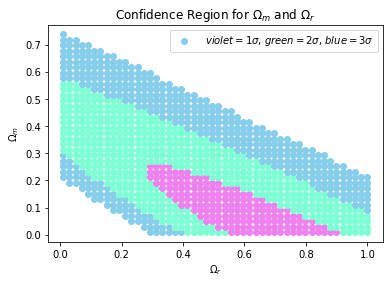

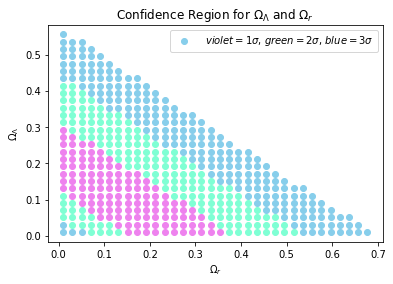

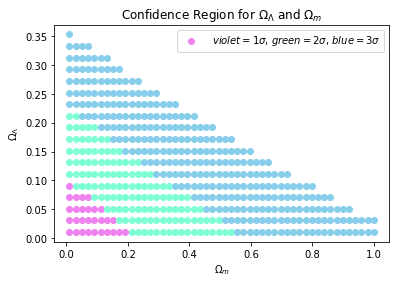

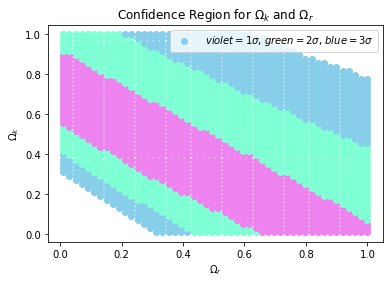

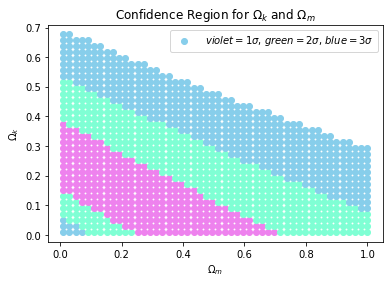

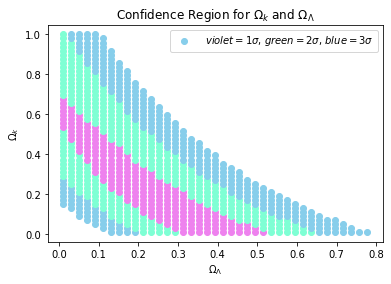

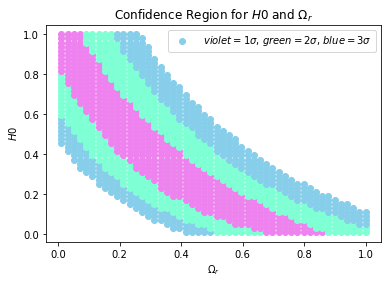

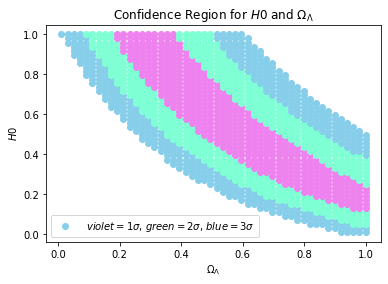

In [18]:
#-2lnL from the best fit
theta_fit = fit_all.x
f2lnL_all = f_2lnL_all(theta_fit)

#Intervals to the confidance test and plot
int1 = np.linspace(50 ,100, 50)
int2 = np.linspace(0.01 ,1, 50)
int3 = np.linspace(0.01 ,1, 50)
int3 = np.linspace(0.01 ,1, 50)
int4 = np.linspace(0.01 ,1, 50)
inter =[int1, int2, int3, int2, int3]


#Define the confidence interval and plot
for k in range(8):
    for i in range(50):
        for j in range(50):
            
            theta1 = [theta_fit[0], theta_fit[1], theta_fit[2], inter[3][i], inter[4][j]]      #fixing theta[0], theta[1], theta[2]
            theta2 = [theta_fit[0], theta_fit[1], inter[2][i], theta_fit[3], inter[4][j]]      #fixing theta[0], theta[1], theta[3]
            theta3 = [theta_fit[0], theta_fit[1], inter[2][i], inter[3][j], theta_fit[4]]      #fixing theta[0],theta[1], theta[4]
            theta3 = [theta_fit[0], inter[1][i], theta_fit[2], theta_fit[3], inter[4][j]]      #fixing theta[0],theta[2], theta[3]
            theta4 = [theta_fit[0], inter[1][i], theta_fit[2], inter[3][j], theta_fit[4]]      #fixing theta[0],theta[2], theta[4]
            theta5 = [theta_fit[0], inter[1][i], inter[2][j], theta_fit[3], theta_fit[4]]      #fixing theta[0],theta[3], theta[4]
            theta6 = [inter[0][i], theta_fit[1], theta_fit[2], theta_fit[3], inter[4][j]]      #fixing theta[1],theta[2], theta[3]
            theta7 = [inter[0][i], theta_fit[1], inter[2][j], theta_fit[3], theta_fit[4]]      #fixing theta[1],theta[3], theta[4]
            theta8 = [inter[0][i], theta_fit[1], theta_fit[2], inter[3][j], theta_fit[4]]      #fixing theta[1],theta[2], theta[4]
        
            theta = [theta1, theta2, theta3, theta4, theta5, theta6, theta7, theta8]

            lambda_f = (f_2lnL_all(theta[k])/ f2lnL_all)
            
            intervals =[[inter[3][i], inter[4][j]], [inter[3][i], inter[4][j]],
                        [inter[3][i], inter[4][j]], [inter[3][i], inter[4][j]],
                        [inter[3][i], inter[4][j]], [inter[3][i], inter[4][j]],
                        [inter[3][i], inter[4][j]], [inter[3][i], inter[4][j]],
                        [inter[3][i], inter[4][j]]]
                        
            if  lambda_f < chi_list[0]:
                plt.scatter(intervals[k][0], intervals[k][1], color = 'violet')
                

            elif chi_list[0] < lambda_f < chi_list[1]:
                plt.scatter(intervals[k][0], intervals[k][1], color = 'aquamarine')
                

            elif chi_list[1] < lambda_f < chi_list[2]:
                plt.scatter(intervals[k][0], intervals[k][1], color = 'skyblue')
                

        
    labels = [['\Omega_m','\Omega_r'], ['\Omega_\Lambda', '\Omega_r'],
               ['\Omega_\Lambda', '\Omega_m'], ['\Omega_k', '\Omega_r'],
               ['\Omega_k', '\Omega_m'], ['\Omega_k', '\Omega_\Lambda'],
               ['H0', '\Omega_r'],['H0', '\Omega_\Lambda'], ['H0', '\Omega_m']]
    
    plt.title(f'Confidence Region for ${labels[k][0]}$ and ${labels[k][1]}$')
                        
    plt.ylabel(f'${labels[k][0]}$')
    plt.xlabel(f'${labels[k][1]}$')
    plt.legend([f' $violet = 1\sigma$, $green = 2\sigma$, $blue = 3\sigma$ '])
    plt.show()



### D) Likelihood ratio test

In [19]:
theta1 = fit.x #Omegak0, Omegam0 = 0
theta2 = fit_all.x

L1 = np.exp(f_2lnL(theta1)) *(-0.5)
L2 = np.exp(f_2lnL_all(theta2)) *(-0.5)

l = L1/L2

print(l)

1.0000089727027395


Since the ratio $\lambda$ ~ 1, so the hypothesis $\Omega_{k0} = \Omega_{r0} = 0$ is reasonable.